# Task 1: Visualizing oil spills in NY State
Sofia Sarak

**Github Repository:**
https://github.com/sofiasarak/eds220-hwk3

## Complete Workflow

Text(-0.2, -0.65, 'Note: 1 spill at the Tuscarora Indian Reservation was manually added to Niagara county (not previously included)')

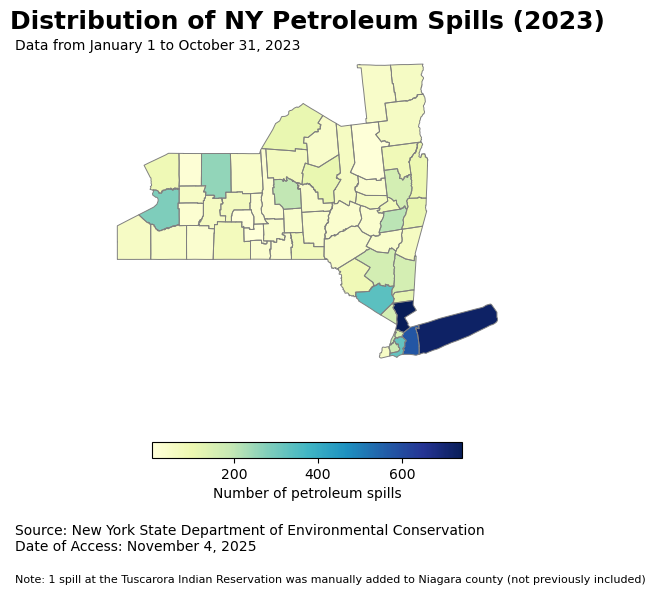

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import data

# Use os library to create a file path describing location of spills data csv
fp = os.path.join('data', 'Spill_Incidents_20251103.csv')
# Read in spills data using predetermined file path and geopandas library
spills = gpd.read_file(fp)

# Use os library to create file path for counties data
fp = os.path.join('data', 'tl_2023_us_county', 'tl_2023_us_county.shp')
# Read in counties data using fp and geopandas
counties = gpd.read_file(fp)

# Prepare spills data

# Simplify column names
spills.columns = spills.columns.str.lower().str.replace(' ','_')

# Convert `spill_date` column to a datetime object to aid in future subsetting
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Data selection: only values from January 1 to October 31, 2023

# Subset data based on 3 comparisons
# 1. spill_date is greater than (after) January 1, 2023
# 2. spill_date is less than (before) October 31, 2023
# 3. material_family is "Petroleum", to select only petroleum spills
petr_23 = spills[(spills['spill_date'] >= pd.to_datetime('2023-01-01')) &  # converting dates to datetime objects for comparison
                 (spills['spill_date'] <= pd.to_datetime('2023-10-31')) &
                 (spills['material_family'] == "Petroleum")]

# Ensure petr_23 only has data for petroleum spills
assert petr_23['material_family'].unique() == np.array(['Petroleum'])

# Creating spills_per_county data frame

# From petr_23, group by county and count the number of observations in each
# Method .reset_index() ensures index is integers starting at 0
summary_by_county = petr_23.groupby('county').count().reset_index()

# Select only the columns we want, and rename spill_number column to n_spills
# In this case all columns contain n_spills (since it is just the number of observations), so any other column could be selected, too
spills_per_county = summary_by_county[['county', 'spill_number']].rename(columns = {'spill_number': 'n_spills'})

# Prepare counties data

# Simplify column names
counties.columns = counties.columns.str.lower()

# Select only NY counties (=='36' from metadata)
ny_counties = counties[counties['statefp'] == '36']

# Data updates (preparing for merge)

# Locate where `county` is equal to 'St Lawarence' using .loc, and replace
spills_per_county.loc[spills_per_county['county'] == 'St Lawrence', 'county'] = 'St.Lawrence'

# Merge two data frames

# In order to join data frames, they must share a column name
# Rename `name` in ny_counties to be `county` to match that of `spills_per_county`
ny_counties = ny_counties.rename(columns = {"name": "county"})

# The .merge() function takes an argument for the type of join and the column to be joined by
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how = "inner",
                       on = "county")

# Adding 1 to Tuscarora Indian Reservation 

# In order to access county based on name, we set `county` column as index
ny_counties = ny_counties.set_index('county')

# Manually add 1 to the `n_spills` column at 'Niagara
ny_counties.at['Niagara', 'n_spills'] += 1

# Map

# Iniatlize figure with one axes
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis
ax.axis('off')

# Plot ny_counties boundary to obtain county outlines
ny_counties.boundary.plot(ax = ax,
                          color = "gray",
                          linewidth = 0.7)

# Plot ny_counties, coloring by the number of petroleum spills in each
ny_counties.plot(ax = ax,
                 column = "n_spills",
                 legend = True,
                 cmap = "YlGnBu",
                 legend_kwds={"label": "Number of petroleum spills",        # Specify legend title
                              "orientation": "horizontal",                  
                              "shrink": 0.5})                               # Make legend smaller

# Add title and make it larger and bolded, with extra space before plot
ax.set_title("Distribution of NY Petroleum Spills (2023)", fontsize=18, weight='bold', pad=15)

# Add annotations to bottom left of axes
ax.annotate("Source: New York State Department of Environmental Conservation", xy = (-.2, -.5), xycoords = "axes fraction")
ax.annotate("Date of Access: November 4, 2025", xy = (-.2, -.55), xycoords = "axes fraction")
ax.annotate("Data from January 1 to October 31, 2023", xy = (-.2, 1), xycoords = "axes fraction")
ax.annotate("Note: 1 spill at the Tuscarora Indian Reservation was manually added to Niagara county (not previously included)",
             xy = (-.2, -.65), xycoords = "axes fraction", fontsize = 8)
